# <center><span style='color:red'>Detect Churn Using CRISP-DM</span></center>

The data set in study here contains details of a bank's customers and the target variable Exited is a binary variable which reflects whether the customer closed his account and left the bank or not.

Data source : https://www.kaggle.com/shrutimechlearn/churn-modelling

The business questions we are trying to answer among other are mainly :
1. what is the percentage of people churning in the dataset ?
2. how are demographics (such as : Gender, Age) different between the two populations of churners and non-churners
3. what are the features that drive the churn the most

other insights will be presented as we develop our analysis in the notebook !

----

In [1]:
#!pip install --user imblearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.preprocessing import MinMaxScaler

In [4]:
from imblearn.under_sampling import RandomUnderSampler

In [5]:
data_path = 'data\\churn-modelling\\'

In [40]:
data = pd.read_csv(data_path + 'Churn_Modelling.csv')
print(data.shape)
data.head()

(10000, 14)


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [41]:
print('list of columns with their type : ')
data.dtypes

list of columns with their type : 


RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

so first let's start our journey as light as possible, we will not need the next columns for our analysis therefore better remove them

In [42]:
data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)

In [43]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [9]:
data.describe()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


using the describe function we can get an idea how the different columns are ditributed:
- for instance we can clearly see that the mean age in our dataset is around 38 years old
- the balance ranges from a minimum of 0 to a maximum of 250898 usd
- the max number of products is 4

let's see the percentage of people who exited and the ones who stayed:

In [10]:
print(data.Exited.value_counts()/data.shape[0] * 100)

0    79.63
1    20.37
Name: Exited, dtype: float64


as we can see the majority of people in the dataset around 80% has remained, which is normal. the churn in most cases concerns a minority of the population, unless the company (be it a bank or other) is facing a serious problem in running its business. the same is for Fraud!

let's try to use visualisation to have a sense of the different features we hold :

#### Feature : Age

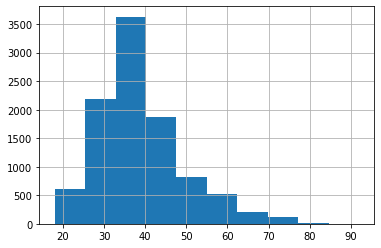

In [11]:
data.Age.hist()
plt.savefig('images/age_histogram.png')

as we can see the histogram only confirms what we saw before in the result of describe method, most of the customer have an age between 35 and 40 years

using another type of visualisation, namely a boxplot we can see clearly that we have few outliers, which can be also seen in the histogram before, where we do have a long tail towards the right (customer with an age > 75)

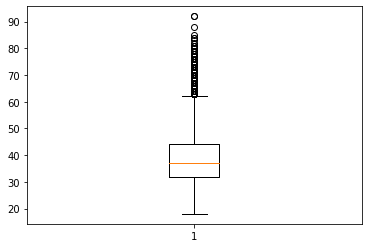

In [12]:
plt.boxplot(x=data['Age'])
plt.savefig('images/age_boxplot.png')

#### Handle missing data

In [13]:
# let's check if there is any missing data ?
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

luckily no data is missing !

#### Feature : Balance 

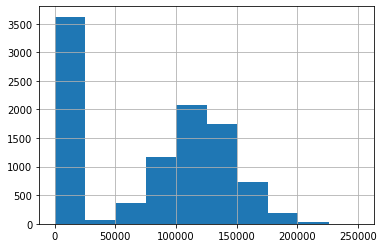

In [14]:
# let draw a histogram
data.Balance.hist()
plt.savefig('images/balance_histogram.png')

a better way to draw a histogram is by emphasising the diffrence with regard to the target value (Exited)
this type of visualisation is be very useful, in the sense that when we have two distinctive histograms, that is a good hint in that the feature concerned can be detrimental in predicting the target feature.

in the next example, be it the remaining customers or the ones that left, both have a similar distribution with regard to Balance.

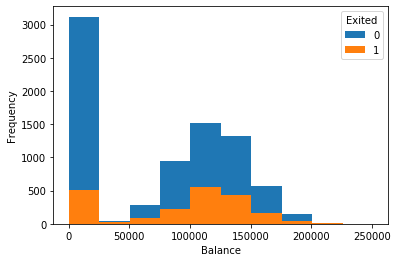

In [15]:
# pivot and plot
data.pivot(columns="Exited", values="Balance").plot.hist() # hist(bins=100)
plt.xlabel('Balance')
plt.savefig('images/balance_Exited_histogram.png')

when we draw the same plot for the Age feature we can find that there is a slight deviation however not a strong one.

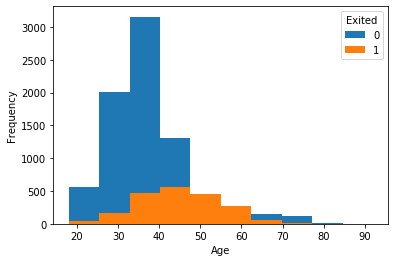

In [16]:
# pivot and plot
data.pivot(columns="Exited", values="Age").plot.hist() # hist(bins=100)
plt.xlabel('Age')
plt.savefig('images/Age_Exited_histogram.png')

let's try another type of visualisation while putting focus on the gender which a categorical feature:

#### Handle categorical

In [17]:
data.Gender.unique()

array(['Female', 'Male'], dtype=object)

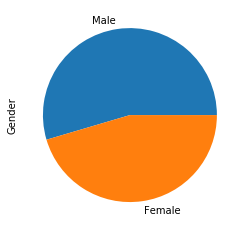

In [18]:
data.Gender.value_counts().plot.pie()
plt.savefig('images/gender_pie.png')

most of the bank's customers are male apparently

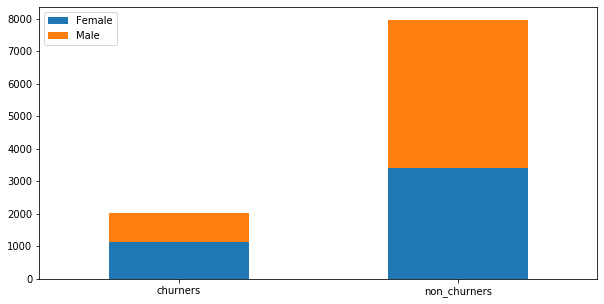

In [52]:
churners = data[data['Exited']==1]['Gender'].value_counts()
non_churners = data[data['Exited']==0]['Gender'].value_counts()
churn = pd.DataFrame([churners,non_churners])
churn.index = ['churners','non_churners']
churn.plot(kind='bar',stacked=True, figsize=(10,5), rot=0)
plt.savefig('images/gender_exited_stacked_bar.png')

from this plot we can state that most of churners are female while most of non-churners are male

since we entend using a machine learning model later for predicting the churn, we better make some transformations on our categorical data:

In [20]:
# replacing Male : 1 and other (Female) : 0
data.Gender = [1 if each == 'Male' else 0 for each in data.Gender]
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


we don't have much categorical fields in this dataset, so let's see what we have in the second categorical feature : Geography

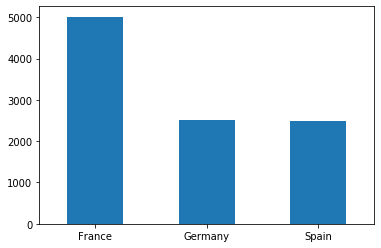

In [51]:
data.Geography.value_counts().plot(kind='bar',rot=0);
plt.savefig('images/geography_bar.png')


our customers are located in three different countries, namely: France, Germany and Spain

a majority are based in France

for data preparation in this case we are going to use the next functiomn : handle_categorical_data

In [22]:
def handle_categorical_data(df, col):
    """
    generates dummies for the categorical feauture : col
    
    INTPUT 
    df - dataframe
    col - string : categorical column
    
    OUTPUT
    df = dataframe with dummies and original column deleted
    """
    
    df_dummies = pd.get_dummies(df[col], prefix=col)
    df = df.join(df_dummies)
    df.drop(col,axis=1, inplace=True)
    return df

In [23]:
data = handle_categorical_data(data, 'Geography')
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,0,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,0,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,0,43,2,125510.82,1,1,1,79084.10,0,0,0,1


one of my favorite visualisations is the violon.
next we can see that for the credit score for both populations the mean as well as the inter-quartile range are not very different 
however we can notice one major differences : in the churner population, we can see that it contains more customer who have very low credit score

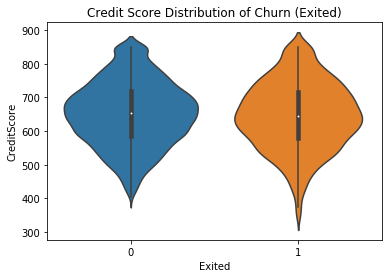

In [24]:
# Exited -- CreditScore
sns.violinplot( x=data["Exited"], y=data["CreditScore"], linewidatah=5)
plt.title("Credit Score Distribution of Churn (Exited)")
plt.savefig('images/creditScore_exited_violin.png')

finally, let's see if we can detect in correlation between the features:

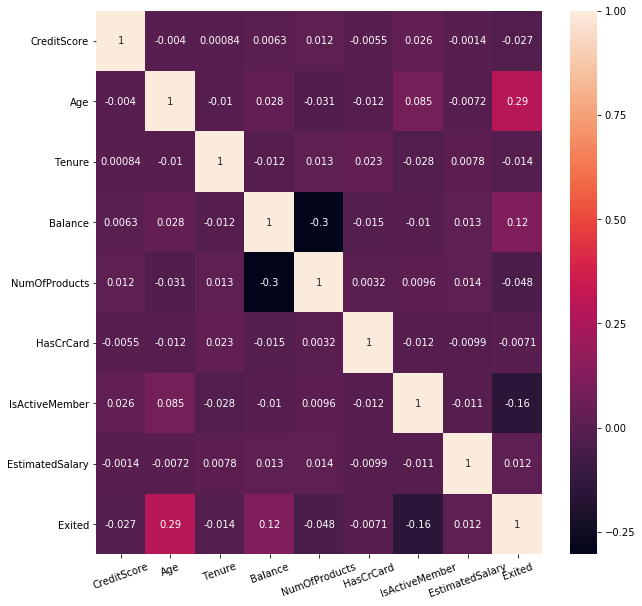

In [57]:
import seaborn as sns
corr = data.corr()
plt.figure(figsize=(10,10))

ax = sns.heatmap(corr, annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.xticks(rotation=20) 
plt.savefig('images/corr_heatmap.png')

so now let's get into modelisation :
- train/test split
- train model 
- evaluate the model 

### train/test split

In [26]:
X,y = data.drop('Exited',axis=1), data.Exited

In [27]:
# having a 70/30 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [28]:
print(X_train.shape , y_train.shape)
print(X_test.shape , y_test.shape)

(7000, 12) (7000,)
(3000, 12) (3000,)


### modelisation

### basic model : LogisticRegression

In [29]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.8006666666666666


Many beginners in data science and machine learning, would think that we achieved a really good model, but let's not hurry up things, let's look into the confusion matrix:

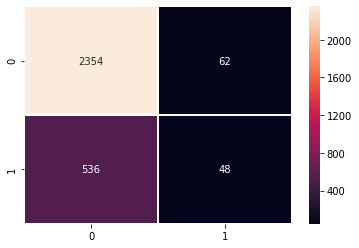

In [31]:
conf_matrix = confusion_matrix(y_test.tolist(), y_pred.tolist())
ax = sns.heatmap(conf_matrix, annot=True, linewidth=0.7,  fmt='.0f')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('images/confusion_matrix.png')

as you can see we mis-classifier many cases! the reason why we achieved a high accuracy is due to the data imbalance (remember 70% of the cases are not churn)
in other word if we have just a dummy model that guesses '0' each time we will end up with a very good accuracy.
let's try another evaluation metric which is more resilient to such cases:

In [32]:
print(f1_score(y_test, y_pred))

0.13832853025936598


#### logistic regression with cross validation

In [33]:
np.mean(cross_val_score(lr, X, y, cv=5, scoring='f1'))

0.09871537969226726

### Another model : RandomForest

In [34]:
rf = RandomForestClassifier()
np.mean(cross_val_score(rf, X, y, cv=5, scoring='f1'))

0.5838395384197359

### normalizing the data

In [35]:
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
rf = RandomForestClassifier()
np.mean(cross_val_score(rf, X_norm, y, cv=5, scoring='f1'))

0.5838605777174517

### balancing the data

let's use the imblear library to try and balance the dataset with regard to the target value and see if we can improve our results:

In [36]:
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X, y)

np.mean(cross_val_score(rf, X_rus, y_rus, cv=5, scoring='f1'))

0.7564674969684704

as you can see we achieved a better performance by balancing the data

### Feaurer importance 
I'm very interested to see what feature according to model we built are the most important :

In [37]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [38]:
feature_importances = pd.DataFrame({'features':X.columns,
                                    'importance':rf.feature_importances_})\
.sort_values(by='importance', ascending=False)

feature_importances

,features,importance
2,Age,0.236830
0,CreditScore,0.146393
8,EstimatedSalary,0.142707
4,Balance,0.141020
5,NumOfProducts,0.128010
3,Tenure,0.083835
7,IsActiveMember,0.041805
10,Geography_Germany,0.020315
1,Gender,0.019854
6,HasCrCard,0.018743


Apparently, Age, Credit Score, Salary and the number of products the customer holds are the major features that drive the churn

### conclusion

Throught out this notebook we managed to do an analysis of a bank's customers using the CRISP-DM method.
we prepared data, visualised it and were able to create ML model for prediction.
we saw how choosing the wrong metric while evaluating an ML model can misguide us with regard to its performance.
we tried different models with different techniques (normalizing, balancing) to try to improve performance.


### deliverables :
* Github repo : https://github.com/oumoussmehdi/Udacity/tree/master/DSBP
* Blog post : https://medium.com/@oumousselmehdi/detect-churn-using-crisp-dm-60d6553dd531